In [109]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout ,SimpleRNN , Bidirectional
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
var='ETH'

In [110]:
df = pd.read_csv(f'Dataset\\{var}-USD(1).csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

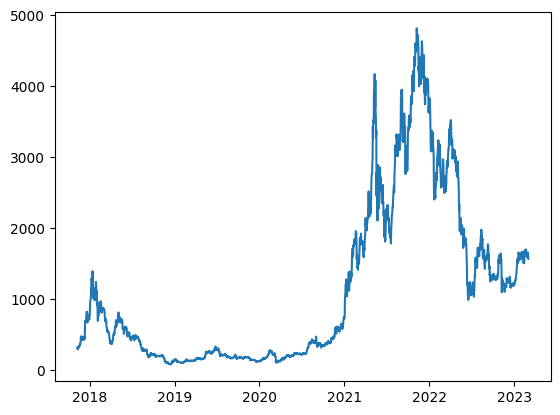

In [111]:
plt.plot(df.index,df['Close'])
plt.savefig(f"Unscaled_{var}.png")

In [112]:
scaler = MinMaxScaler(feature_range=(-1, 1))
def create_dataset(df, window):
    scaled_data = scaler.fit_transform(df[['Close']])

    X = []
    y = []

    for i in range(window, len(scaled_data)):
        X.append(scaled_data[i-window:i])
        y.append(scaled_data[i])

    X, y = np.array(X), np.array(y)
    
    return X, y

In [113]:
def test_train_split(X,y):
    cv_size = int(0.2 * len(X))

    start_idx = np.random.randint(0, len(X) - cv_size)

    X_cv = X[start_idx:start_idx+cv_size]
    y_cv = y[start_idx:start_idx+cv_size]

    X_train = np.delete(X, np.s_[start_idx:start_idx+cv_size], axis=0)
    y_train = np.delete(y, np.s_[start_idx:start_idx+cv_size], axis=0)

    train_size = int(0.8 * len(X_train))
    X_train1, X_test = X_train[:train_size], X_train[train_size:]
    y_train1, y_test = y_train[:train_size], y_train[train_size:]

    return X_train1 , X_test , y_train1,y_test , X_cv,y_cv


In [114]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def metrics(y_test,pred,model):
    rmse = np.sqrt(mean_squared_error(y_test.reshape(-1,1),pred))
    r2 = r2_score(y_test.reshape(-1,1), pred)
    mae = mean_absolute_error(y_test.reshape(-1,1), pred)
    mape_score = mape(y_test.reshape(-1,1), pred)
    print(f"{model}\nrmse:{rmse}\nr2:{r2}\nmae:{mae}\nmape:{mape_score}\n\n")

In [115]:
def plot_predictions(predictions_, var):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14,5))
    plt.plot(df.index, df['Close'], color = 'red', label = f'Real {var} Price')
    plt.plot(df.index[len(df) - len(predictions_):], predictions_, color = 'blue', label = f'Predicted {var} Price (LSTM)')
    plt.title(f'{var} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{var} Price')
    plt.legend()
    plt.savefig(f"{var}Test-Train_plot.png")

# Stacked LSTM

In [187]:
X, y = create_dataset(df, 40)
X_train1 , X_test,y_train1,y_test,X_cv,y_cv=test_train_split(X,y)

In [188]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(40,1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50,return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

In [189]:
optimizer = Adam(learning_rate=0.001)
op=SGD(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_absolute_error')

In [190]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 40, 50)            10400     
                                                                 
 dropout_12 (Dropout)        (None, 40, 50)            0         
                                                                 
 bidirectional_16 (Bidirecti  (None, 40, 100)          40400     
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 40, 100)           0         
                                                                 
 lstm_36 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_14 (Dropout)        (None, 50)                0         
                                                     

In [191]:
history2=model.fit(X_train1,y_train1,epochs=100,batch_size=32,validation_data=(X_cv,y_cv))

Epoch 1/100
38/38 [==============================] - 7s 60ms/step - loss: 0.1654 - val_loss: 0.0241
Epoch 2/100
38/38 [==============================] - 1s 28ms/step - loss: 0.0939 - val_loss: 0.0070
Epoch 3/100
38/38 [==============================] - 1s 26ms/step - loss: 0.0925 - val_loss: 0.1222
Epoch 4/100
38/38 [==============================] - 1s 28ms/step - loss: 0.0890 - val_loss: 0.0053
Epoch 5/100
38/38 [==============================] - 1s 26ms/step - loss: 0.0771 - val_loss: 0.0425
Epoch 6/100
38/38 [==============================] - 1s 26ms/step - loss: 0.0769 - val_loss: 0.0250
Epoch 7/100
38/38 [==============================] - 1s 25ms/step - loss: 0.0752 - val_loss: 0.0079
Epoch 8/100
38/38 [==============================] - 1s 27ms/step - loss: 0.0744 - val_loss: 0.0561
Epoch 9/100
38/38 [==============================] - 1s 25ms/step - loss: 0.0771 - val_loss: 0.0209
Epoch 10/100
38/38 [==============================] - 1s 26ms/step - loss: 0.0694 - val_loss: 0.0157

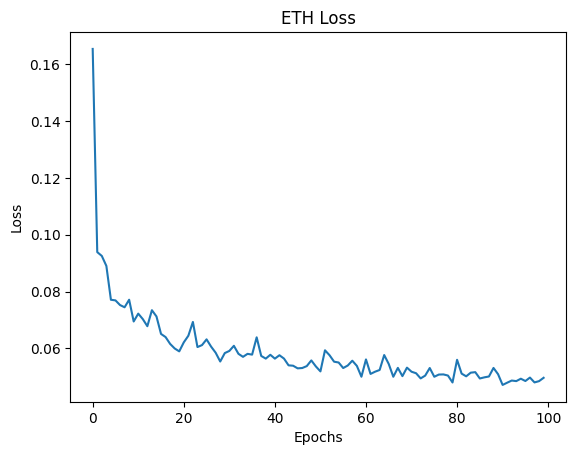

In [192]:
plt.plot(history2.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f"{var} Loss")
plt.savefig(f"{var}_loss.png")

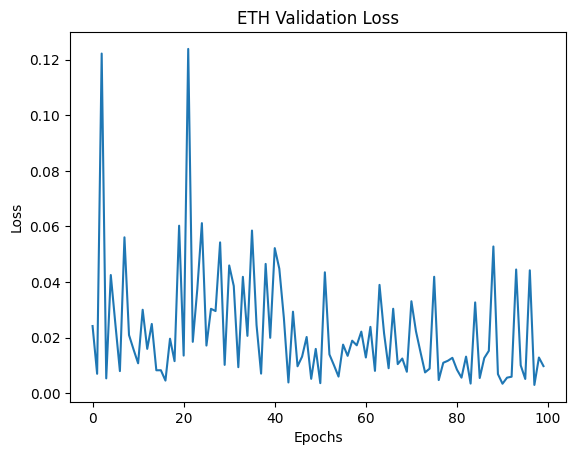

In [193]:
plt.plot(history2.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f"{var} Validation Loss")
plt.savefig(f"{var}_val_loss.png")

In [194]:
predictions = model.predict(X_test)
predictions_ = scaler.inverse_transform(predictions.reshape(-1,1))

In [195]:
metrics(scaler.inverse_transform(y_test),predictions_,"Stacked LSTM Inverse Scaled Data")

Stacked LSTM Inverse Scaled Data
rmse:81.13453357284709
r2:0.9323330323246198
mae:56.26239091424181
mape:3.7312680513343714




In [196]:
metrics(y_test,predictions,"Stacked LSTM")

Stacked LSTM
rmse:0.03432247056132474
r2:0.9323330389629704
mae:0.02380076725919866
mape:8.284958832852876




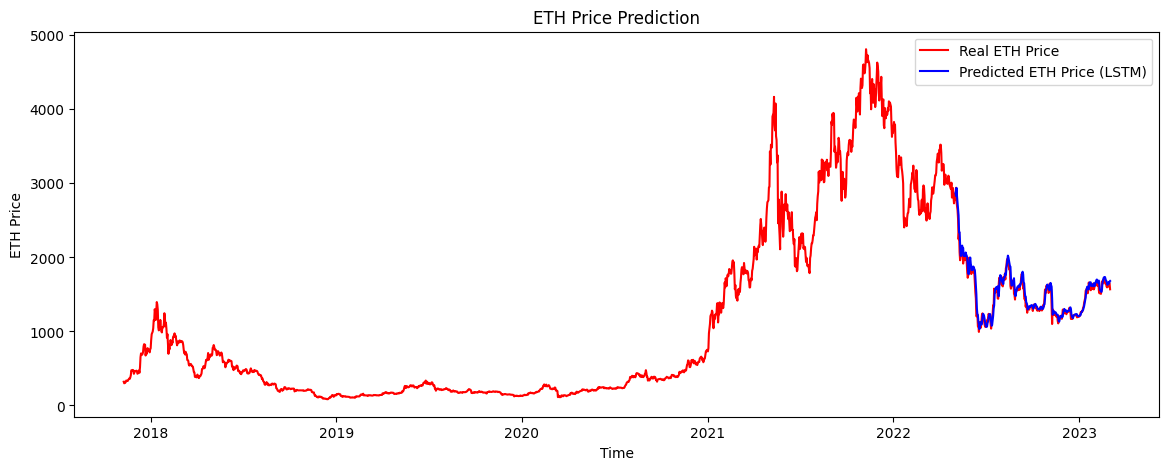

In [197]:
plot_predictions(predictions_,"ETH")

# *(RNN-LSTM)*

In [126]:
X, y = create_dataset(df, 3)
X_train1 , X_test,y_train1,y_test,X_cv,y_cv=test_train_split(X,y)

In [127]:

base_model=Sequential()
base_model.add(SimpleRNN(units=32, return_sequences=True, input_shape=(3, 1))) 
base_model.add(LSTM(units=50, return_sequences=True))
base_model.add(LSTM(units=50))
base_model.add(Dense(units=1))  


In [128]:
optimizer = Adam(learning_rate=0.01)
op=SGD(learning_rate=0.001)
base_model.compile(optimizer=optimizer, loss='mean_absolute_error')

In [129]:
base_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 3, 32)             1088      
                                                                 
 lstm_25 (LSTM)              (None, 3, 50)             16600     
                                                                 
 lstm_26 (LSTM)              (None, 50)                20200     
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 37,939
Trainable params: 37,939
Non-trainable params: 0
_________________________________________________________________


In [130]:
history = base_model.fit(X_train1, y_train1, epochs=100, batch_size=16,validation_data=(X_cv,y_cv))

Epoch 1/100


78/78 [==============================] - 5s 24ms/step - loss: 0.0887 - val_loss: 0.1113
Epoch 2/100
78/78 [==============================] - 1s 13ms/step - loss: 0.0592 - val_loss: 0.0279
Epoch 3/100
78/78 [==============================] - 1s 14ms/step - loss: 0.0561 - val_loss: 0.0161
Epoch 4/100
78/78 [==============================] - 1s 13ms/step - loss: 0.0581 - val_loss: 0.0619
Epoch 5/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0468 - val_loss: 0.0351
Epoch 6/100
78/78 [==============================] - 1s 13ms/step - loss: 0.0404 - val_loss: 0.0423
Epoch 7/100
78/78 [==============================] - 1s 13ms/step - loss: 0.0463 - val_loss: 0.0143
Epoch 8/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0533 - val_loss: 0.0220
Epoch 9/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0490 - val_loss: 0.0138
Epoch 10/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0398 - val_loss: 0.0182
Epoch 11/10

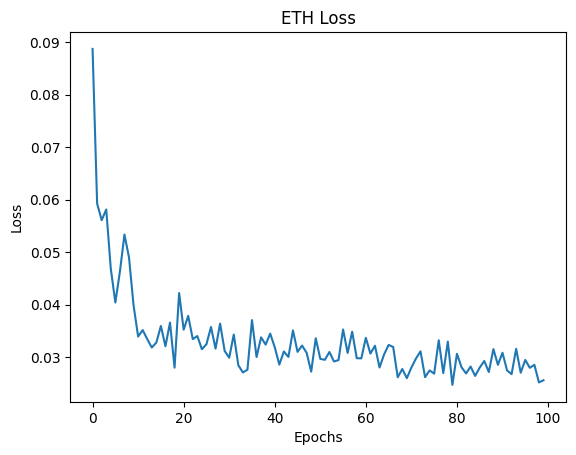

In [131]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f"{var} Loss")
plt.savefig(f"{var}_loss.png")

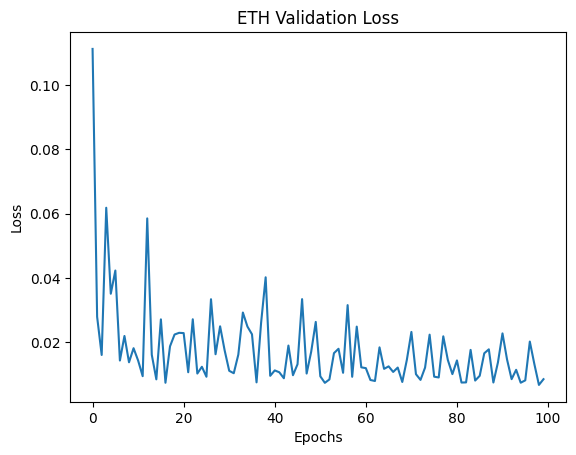

In [132]:
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f"{var} Validation Loss")
plt.savefig(f"{var}_val_loss.png")

In [133]:
predictions = base_model.predict(X_test)
predictions_ = scaler.inverse_transform(predictions.reshape(-1,1))

In [134]:
metrics(y_test,predictions,"Base Model")

Base Model
rmse:0.03146746214696858
r2:0.9572521899910674
mae:0.022626365387076165
mape:8.02533020538303




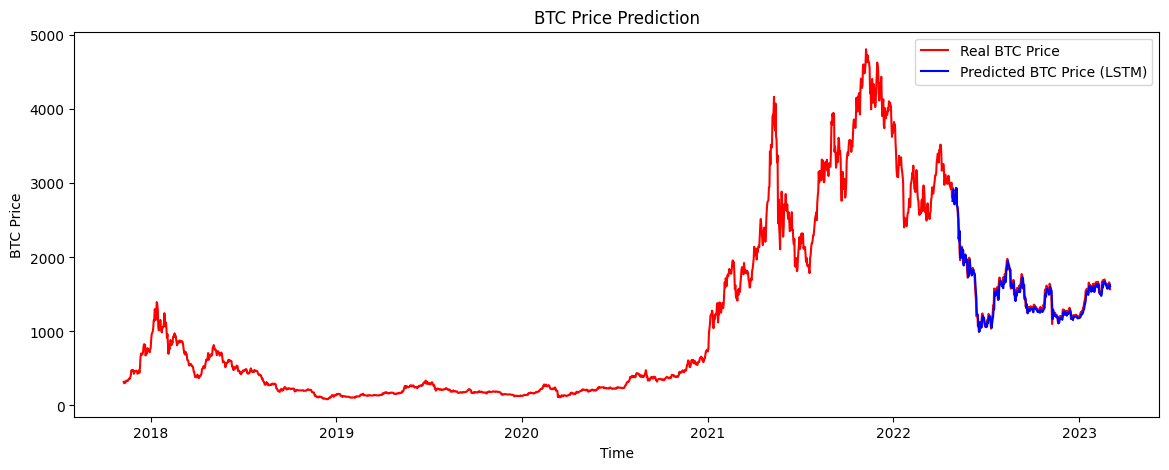

In [135]:
plot_predictions(predictions_,"BTC")

## Base Model RNN-BiLSTM

In [144]:

base_model2=Sequential()
base_model2.add(SimpleRNN(units=50, return_sequences=True, input_shape=(3, 1)))
base_model2.add(Bidirectional(LSTM(units=25, return_sequences=True)))
base_model2.add(Bidirectional(LSTM(units=25)))
base_model2.add(Dense(units=1))  


In [145]:
optimizer = Adam(learning_rate=0.01)
op=SGD(learning_rate=0.001)
base_model2.compile(optimizer=optimizer, loss='mean_absolute_error')

In [166]:
history3 = base_model2.fit(X_train1, y_train1, epochs=100, batch_size=322,validation_data=(X_cv,y_cv))

Epoch 1/100
4/4 [==============================] - 0s 41ms/step - loss: 0.0304 - val_loss: 0.0113
Epoch 2/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0268 - val_loss: 0.0099
Epoch 3/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0243 - val_loss: 0.0158


Epoch 4/100
4/4 [==============================] - 0s 53ms/step - loss: 0.0229 - val_loss: 0.0078
Epoch 5/100
4/4 [==============================] - 0s 33ms/step - loss: 0.0217 - val_loss: 0.0077
Epoch 6/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0217 - val_loss: 0.0072
Epoch 7/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0212 - val_loss: 0.0084
Epoch 8/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0208 - val_loss: 0.0090
Epoch 9/100
4/4 [==============================] - 0s 34ms/step - loss: 0.0205 - val_loss: 0.0097
Epoch 10/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0204 - val_loss: 0.0080
Epoch 11/100
4/4 [==============================] - 0s 35ms/step - loss: 0.0202 - val_loss: 0.0085
Epoch 12/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0210 - val_loss: 0.0112
Epoch 13/100
4/4 [==============================] - 0s 30ms/step - loss: 0.0209 - val_loss: 0.0093
Epoch 14/100
4/4

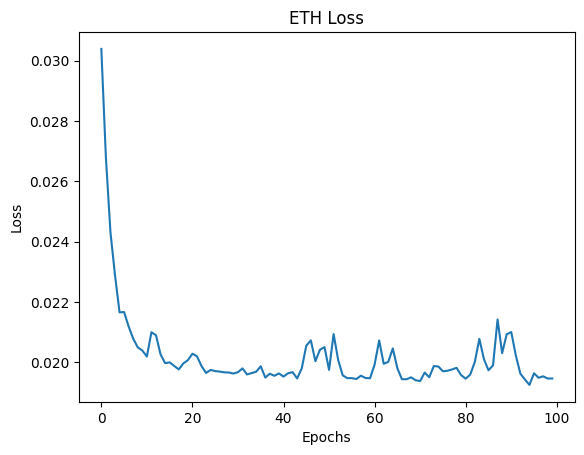

In [167]:
plt.plot(history3.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f"{var} Loss")
plt.savefig(f"{var}_loss.png")

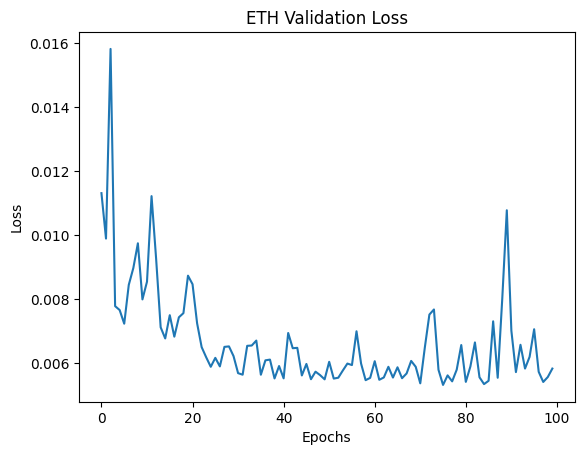

In [168]:
plt.plot(history3.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f"{var} Validation Loss")
plt.savefig(f"{var}_val_loss.png")

In [169]:
predictions = base_model2.predict(X_test)
predictions_ = scaler.inverse_transform(predictions.reshape(-1,1))

In [170]:
metrics(scaler.inverse_transform(y_test),predictions_,"Base Model2 Inverse Scaled Metrics")

Base Model2 Inverse Scaled Metrics
rmse:75.8810809042676
r2:0.9555160761844003
mae:52.171420072736645
mape:3.3976935776782056




In [171]:
metrics(y_test,predictions,"Base Model2")

Base Model2
rmse:0.03210009504085089
r2:0.9555160780449755
mae:0.022070158176128122
mape:8.007089995694235




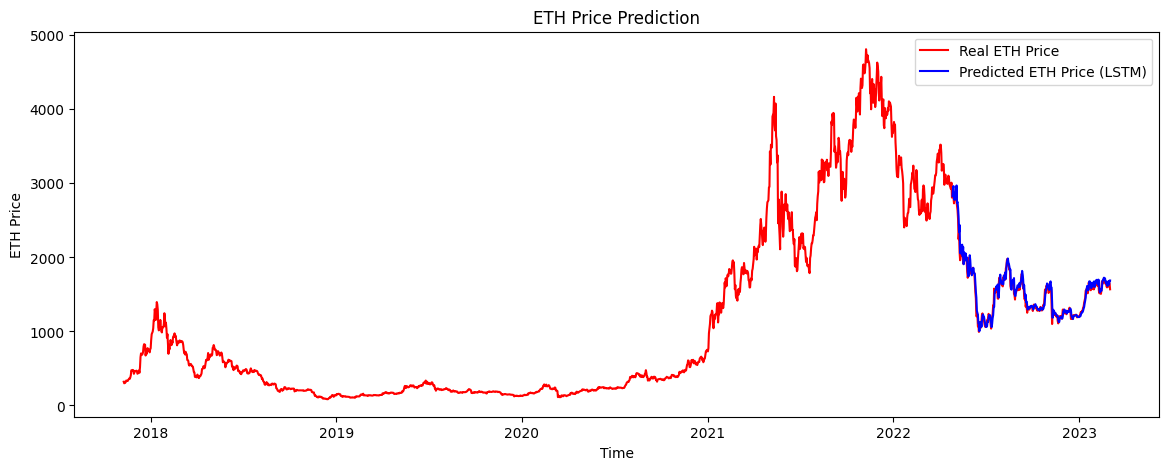

In [172]:
plot_predictions(predictions_,"ETH")

In [173]:
df_test = pd.read_csv(f'Dataset\\{var}-USD.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test.set_index('Date', inplace=True)

In [198]:
scaled_data_test = scaler.transform(df_test[['Close']])

X_test_ = []
y_test_ = []

for i in range(3, len(scaled_data_test)):
    X_test_.append(scaled_data_test[i-3:i])
    y_test_.append(scaled_data_test[i])

X_test_, y_test_ = np.array(X_test_), np.array(y_test_)


In [199]:
predictions_test_1 = base_model2.predict(X_test_)
predictions_test_1_ = scaler.inverse_transform(predictions_test_1.reshape(-1,1))

In [203]:
metrics(y_test_,predictions_test_1,"Base Model 2 (Testset2)")

Base Model 2 (Testset2)
rmse:0.02325528573138273
r2:0.9773431276306409
mae:0.017109620293740534
mape:17.295025578894556




In [205]:
metrics(scaler.inverse_transform(y_test_),predictions_test_1_,"Base Model 2 (Testset2) Inverse Scaled Data")

Base Model 2 (Testset2) Inverse Scaled Data
rmse:54.972921065867794
r2:0.9773431325158715
mae:40.44525513789921
mape:2.0440443911033177




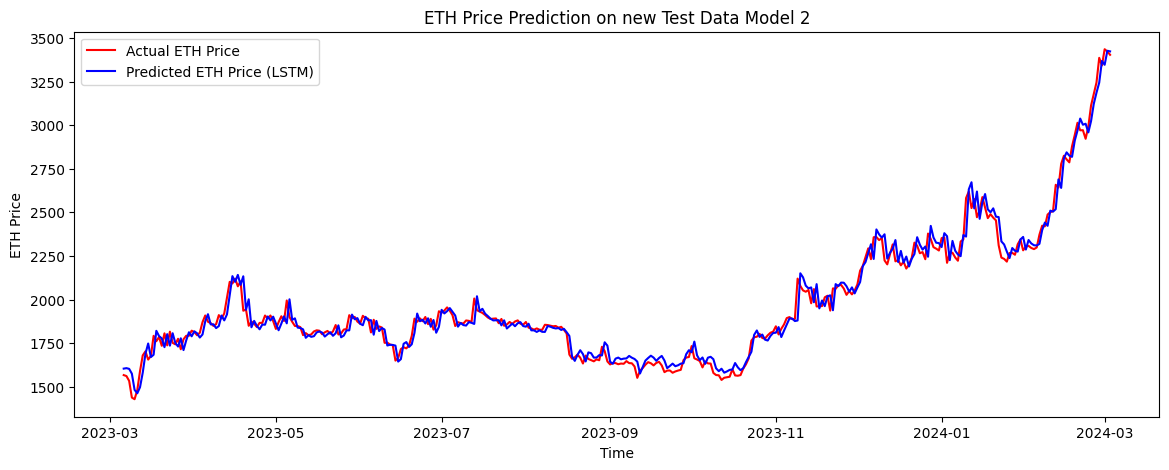

In [207]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,5))
plt.plot(df_test.index[3:],scaler.inverse_transform(y_test_.reshape(-1,1)), color = 'red', label = f'Actual {var} Price')
plt.plot(df_test.index[3:],predictions_test_1_, color = 'blue', label = f'Predicted {var} Price (LSTM)')
plt.title(f'{var} Price Prediction on new Test Data Model 2')
plt.xlabel('Time')
plt.ylabel(f'{var} Price')
plt.legend()
plt.savefig(f"{var} Test.png")

In [208]:
predictions_df = pd.DataFrame(predictions_test_1_,index=df_test.index[3:], columns=[f'Predicted {var} Price'])
predictions_df['Actual Price'] = scaler.inverse_transform(y_test_)

In [209]:
predictions_df

,Predicted ETH Price,Actual Price
Date,,
2023-03-06,1604.546631,1567.398682
2023-03-07,1607.255859,1561.933105
2023-03-08,1603.160889,1534.088257
2023-03-09,1575.502441,1438.660767
2023-03-10,1482.580444,1429.158081
...,...,...
2024-02-28,3243.431152,3385.703857
2024-02-29,3367.712646,3341.919678
2024-03-01,3345.860107,3435.053955


In [ ]:
import tensorflow as tf
tf.config.list_physical_devices()


In [ ]:
tf.test.is_built_with_gpu_support()

In [ ]:
%load_ext tensorboard

In [ ]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras


In [ ]:
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

In [ ]:
import tensorboard
tensorboard.__version__

In [ ]:
%tensorboard --logdir logs

In [ ]:
# model.save("0.987.h5")

In [ ]:
# jsonmodel=model.to_json()
# with open('model.json', 'w') as json_file:
#     json_file.write(jsonmodel)

In [ ]:
# # Recreate the exact same model, including its weights and optimizer
# new_model = tf.keras.models.load_model('0.987.h5')

# # Show the model architecture
# new_model.summary()


In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True , rankdir='TB')
import matplotlib.image as mpimg
img = mpimg.imread('model.png')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
df_test = pd.read_csv('Dataset\\ETH-USD.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test.set_index('Date', inplace=True)
scaled_data_test = scaler.transform(df_test[['Close']])

X_test_ = []
y_test_ = []

for i in range(window, len(scaled_data_test)):
    X_test_.append(scaled_data_test[i-window:i])
    y_test_.append(scaled_data_test[i])

X_test_, y_test_ = np.array(X_test_), np.array(y_test_)
predictions_test_1 = model.predict(X_test_)
predictions_test_1_ = scaler.inverse_transform(predictions_test_1.reshape(-1,1))
print(metrics(scaler.inverse_transform(y_test_),predictions_test_1_))
predictions_df = pd.DataFrame(predictions_test_1_,index=df_test.index[window:], columns=['Predicted BTC Price'])
predictions_df['Actual Price'] = scaler.inverse_transform(y_test_)
print(predictions_df)
print(metrics(y_test_,predictions_test_1))
plt.figure(figsize=(14,5))
plt.plot(df_test.index[window:],scaler.inverse_transform(y_test_.reshape(-1,1)), color = 'red', label = 'Actual BTC Price')
plt.plot(df_test.index[window:],predictions_test_1_, color = 'blue', label = 'Predicted BTC Price (LSTM)')
plt.title('BTC Price Prediction on Test Data')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()